In [1]:
import copy

import IPython
# IPython.Application.instance().kernel.do_shutdown(True)

# %matplotlib notebook 
#import mpld3
#mpld3.enable_notebook()

%matplotlib widget

import os
import sys
import json
import time
import datetime
import pycwt
import statistics
import random
import pickle
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import sklearn as sk
import tkinter as tk
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn import decomposition
from sklearn.decomposition import PCA
from tkinter import *
from tkinter import ttk
from sklearn import preprocessing
from datetime import date
import matplotlib.dates as mdates

from neurodsp.rhythm import sliding_window_matching
from neurodsp.utils.download import load_ndsp_data
from neurodsp.plts.rhythm import plot_swm_pattern
from neurodsp.plts.time_series import plot_time_series
from neurodsp.utils import set_random_seed, create_times
# Import listed chormap
from matplotlib.colors import ListedColormap
import matplotlib.dates as md
from matplotlib import colors as mcolors
# Scipy
from scipy import signal
from scipy import ndimage
# TKinter for selecting files
from tkinter import Tk     # from tkinter import Tk for Python 3.x
from tkinter.filedialog import askdirectory

# Add my module to python path
sys.path.append("../")

# Own libraries
from Neurogram_short import * # Recording, MyWavelet, MyWaveforms
from additional_functions import * 

os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
Tk().withdraw()  # keep the root window from appearing
dir_name = ('../datasets/')

path = '../datasets/rat7&8/day2' 
map_path = '../datasets/map_linear.csv'

# When using port A: channels=range(0,32,1) by default port B:range(32,64,1)
# Start and dur in samples
# feinstein: channels=[0]
time_start = time.time()
load_from_file = True  # Keep it always to true
downsample = 2  # Only when loading from raw - no need to use it
start = 0
dur = None

port = 'Port A'  # Select port A or B for different recordings
record = Recording.open_record(path, start=start, dur=dur,
                               load_from_file=load_from_file,
                               load_multiple_files=True,
                               downsample=downsample,
                               port=port,  # Select recording port
                               map_path=map_path,
                               verbose=0)

# Create directory to save figures
if not os.path.exists('%s/figures/' % (path)):
    os.makedirs('%s/figures/' % (path))
print("Time elapsed: {} seconds".format(time.time() - time_start))

#sys.exit()

../datasets/rat7&8/day2
Loading from file C:/Users/airbl/OneDrive - University of Cambridge/Documents/Cambridge Work IIB/IIB Project/Code/code_Peter/datasets/rat7&8/day2/recording_230816_125923_152623_Port B.pkl
0
stop: 88484032
10000.0
['14', '15', '16', '17', '18', '20']
                                ch_14      ch_15   ch_16   ch_17   ch_18  \
time                                                                       
1970-01-01 00:00:00.000000 -23.400000 -27.299999  -2.340  -5.070 -11.115   
1970-01-01 00:00:00.000100 -19.305000 -12.675000  -4.290  -1.950 -30.420   
1970-01-01 00:00:00.000200 -14.040000  -4.290000  -0.195   2.730 -14.235   
1970-01-01 00:00:00.000300 -26.325001  -7.995000   4.485  -0.780 -11.115   
1970-01-01 00:00:00.000400 -13.845000  -0.195000  10.140  -2.730  -7.800   
...                               ...        ...     ...     ...     ...   
1970-01-01 02:27:28.402700   7.800000   6.825000   5.070   2.730  -8.190   
1970-01-01 02:27:28.402800   6.435000   1.

# All Cells For Setting Up For Filtering:

In [3]:
# Prepare channels

channels = []
for col in record.recording.columns:
    if col.startswith('ch_'):
        # self.recording[col] = self.recording[col].astype('float32')
        channels.append(col.replace('ch_', ''))

In [4]:
# Get current time for saving (avoid overwriting)
now = datetime.datetime.now()
current_time = now.strftime("%d%m%Y_%H%M%S")

In [5]:
## Configuration
# Do not change
options_filter = [
    "None",
    "butter",
    "fir"]  # Binomial Weighted Average Filter

options_detection = [
    "get_spikes_threshCrossing",  # Ojo: get_spikes_threshCrossing needs detects also cardiac 
    # spikes, so use cardiac_window. This method is slower
    "get_spikes_method",  # Python implemented get_spikes() method. Faster
    "so_cfar"]  # Smallest of constant false-alarm rate filter

options_threshold = [
    "positive",
    "negative",
    "both_thresh"]

In [6]:
# Configure
config_text = []
record.apply_filter = options_filter[1]    
record.detect_method = options_detection[1]   # leave it to butter (option 1)                                 
record.thresh_type = options_threshold[0]     # do not use it for now
# Select channel position/number in intan (not channel number in device)

# record.channels = [5,8,13]  # Select the channels to use. E.g. 5,8,13 for the recording you have now. Include 'all' to select all the channels available
record.channels = channels

record.path = path  
config_text = ['Load_from_file %s' %load_from_file, 'Filter: %s'%record.apply_filter, 'Detection: %s'%record.detect_method, 'Threhold type: %s'%record.thresh_type, 'Channels: %s' %record.channels, 'Downsampling: %s' %downsample]
config_text.append('Port %s' %(port))
config_text.append('Start %s, Dur: %s' %(start,dur))
config_text.append('Channels: %s' %record.channels)
# Ramarkable timestamps (in sec) 

group = '1'

print('SELECTED GENERAL CONFIGURATION:')
print('Filter: %s'%record.apply_filter)
print('Detection: %s'%record.detect_method)
print('Threhold type: %s'%record.thresh_type)
print('Channels: %s' %record.channels) 
print('-------------------------------------')

record.select_channels(record.channels) # keep_ch_loc=True if we want to display following the map. Otherwise follow the order provided by selected channels.
print('map_array: %s' %record.map_array)
print('ch_loc: %s' %record.ch_loc)
print('filter_ch %s' %record.filter_ch)
print('column_ch %s' %record.column_ch)

SELECTED GENERAL CONFIGURATION:
Filter: butter
Detection: get_spikes_method
Threhold type: positive
Channels: ['14', '15', '16', '17', '18', '20']
-------------------------------------
map_array: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31]
ch_loc: [14, 15, 16, 17, 18, 20]
filter_ch ['ch_14', 'ch_15', 'ch_16', 'ch_17', 'ch_18', 'ch_20']
column_ch ['14', '15', '16', '17', '18', '20']


In [7]:
# Configure
record.num_rows = 2 #int(round(len(record.filter_ch)/2)) # round(n_components/2) 
record.num_columns = 1 #int(len(record.filter_ch)-round(len(record.filter_ch)/2))+1 
plot_ch = int(record.map_array[record.ch_loc[0]])                                                
print(plot_ch)
print(record.num_rows)
print(record.num_columns)
save_figure = True

14
2
1


In [8]:
# Gain
gain = 1
config_text.append('Gain: %s' %(gain))

In [9]:
# Maximum bpm
bpm = 300
record.set_bpm(bpm) # General max bpm in rat HR. Current neurograms at 180bpm
config_text.append('BPM: %s' %(bpm))

In [10]:
# Final Initialisations - no change

# Initialize dataframe for results 
#----------------------------------------------------
record.rolling_metrics = pd.DataFrame()
record.summary = pd.DataFrame(columns=['Max_spike_rate', 'Min_spike_rate',
                                'Max_amplitude_sum', 'Min_amplitude_sum'])
record.summary.index.name = 'channel'
record.sig2noise = [] #To save the snr for each channel

# Intialize dataframes for wavelet decomposition
#---------------------------------------------------
neural_wvl = pd.DataFrame(columns=record.filter_ch)
neural_wvl_denoised = pd.DataFrame(columns=record.filter_ch)
other_wvl = pd.DataFrame(columns=record.filter_ch)
substraction_wvl = pd.DataFrame(columns=record.filter_ch)

In [11]:
# Config for bandpass filter

filt_config = {
    'W': [400, 4000],  # (max needs to be <fs/2 per Nyquist)
    'None': {},
    'butter': {
            'N': 9,                # The order of the filter
            'btype': 'bandpass', #'bandpass', #'hp'  #'lowpass'     # The type of filter.
    },      
    'fir': {
            'n': 4,
    },
    'notch': {
            'quality_factor': 30,
    },
}

filt_config['butter']['Wn'] = filt_config['W']
filt_config['butter']['fs'] = record.fs

config_text.append('filt_config: %s' %json.dumps(filt_config))

In [12]:
# Apply filter

# Configure
time_start = time.time()
signal2filter = record.recording    # The neural data imported via pkl file 
config_text.append('signal2filter: %s' %signal2filter.name)
record.filter(signal2filter, record.apply_filter, **filt_config[record.apply_filter])
# Change from float64 to float 16
record.filtered = convertDfType(record.filtered, typeFloat='float32')
#print(record.filtered.dtypes)
print("Time elapsed: {} seconds".format(time.time()-time_start))

{'N': 9, 'btype': 'bandpass', 'Wn': [400, 4000], 'fs': 10000.0}
Time elapsed: 211.61272549629211 seconds


# Saving a 5 minute segment as a smaller Pickle file - for GUI development

In [13]:
import pickle

In [14]:
start_time = record.recording.index[0]
end_time = start_time + pd.Timedelta(minutes=5)
segment = record.recording.loc[start_time:end_time]

segment.to_pickle(r"C:\Users\airbl\OneDrive - University of Cambridge\Documents\Cambridge Work IIB\IIB Project\Code\code_Peter\datasets\rat7&8\day2\R7&8_5_minutes.pkl")

# Plot data - wide horizontal

In [14]:
from matplotlib.widgets import Slider

In [15]:
record.channels[0]

'14'

In [16]:
def plot_wide_single_channel(channel=record.channels[0], start_time=None, end_time=None, ylim=None):
    """
    Plots one individual channel really wide, with scroller.
    
    start_time, end_time : [string] in mmmss format e.g. 2 hr 10 min 30 sec -> 13030(xxxx)
                               ....(xxxx) optional - numbers behind the decimal point to specify fractions of a second
    """
    if start_time is None:
        start_index = 0
    else:
        start_index = 0
        start_index += int(start_time[:3]) * 60 * Recording.window_length
        start_index += int(start_time[3:5]) * Recording.window_length
        if len(start_time) == 9:
            start_index += int(start_time[5:])

    if end_time is None:
        end_index = len(record.recording.index)
    else:
        end_index = 0
        end_index += int(end_time[:3]) * 60 * Recording.window_length
        end_index += int(end_time[3:5]) * Recording.window_length
        if len(end_time) == 9:
            end_index += int(end_time[5:])
    
    fig, ax = plt.subplots()
    plt.subplots_adjust(bottom=0.25)
    x_range = [i for i in range(start_index, end_index)]
    signal = record.filtered['ch_%s' % channel][x_range]
    ax.plot(record.recording.index[x_range], signal)
    
    slider_ax = plt.axes([0.1, 0.1, 0.8, 0.03])
    slider = Slider(slider_ax, 'Time', 0, 110, valinit=0, valstep=1)
    
    def update(val):
        pos = slider.val
        ax.set_xlim([record.recording.index[pos], record.recording.index[pos+600*Recording.window_length]])
        fig.canvas.draw_idle()
    
    slider.on_changed(update)
    
    ax.set_title("Channel %s" % channel)
    ax.set_xlabel('Time')
    ax.set_ylabel('Voltage [uV]')
    if ylim is not None:
        ax.set_ylim(ylim[0], ylim[1])
    plt.show()
    

In [27]:
import matplotlib as mpl

In [17]:
%matplotlib notebook 
import mpld3
mpld3.enable_notebook()

In [23]:
# mpl.use('TkAgg')

In [24]:
plot_wide_single_channel(end_time="03000")

18000000


## No Using Functions

In [13]:
start_time = None 
end_time = "03000"
channel = '14'
ylim = None

In [14]:
if start_time is None:
    start_index = 0
else:
    start_index = 0
    start_index += int(start_time[:3]) * 60 * Recording.window_length
    start_index += int(start_time[3:5]) * Recording.window_length
    if len(start_time) == 9:
        start_index += int(start_time[5:])

if end_time is None:
    end_index = len(record.recording.index)
else:
    end_index = 0
    end_index += int(end_time[:3]) * 60 * Recording.window_length
    end_index += int(end_time[3:5]) * Recording.window_length
    if len(end_time) == 9:
        end_index += int(end_time[5:])

In [15]:
from PyQt5.QtCore import QT_VERSION_STR
print("Qt version:", QT_VERSION_STR)


Qt version: 5.15.2


In [17]:
# import matplotlib as mpl
# mpl.use('Qt5Agg')
from matplotlib.widgets import Slider

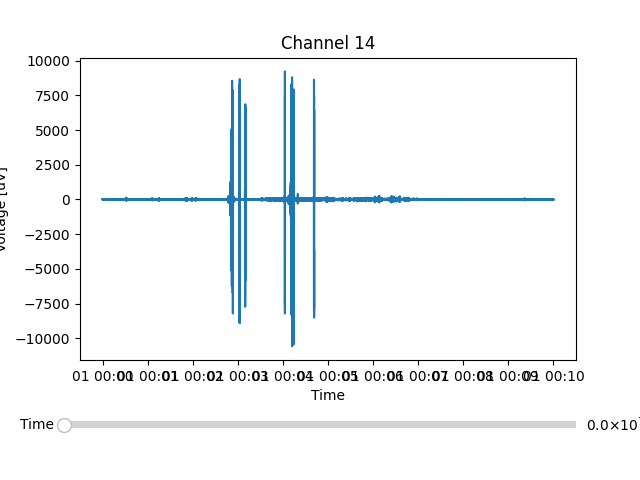

In [20]:
fig, ax = plt.subplots()
plt.subplots_adjust(bottom=0.25)

end_of_display_range = 600 * Recording.window_length
x_range = [i for i in range(start_index, end_of_display_range)]
signal = record.filtered['ch_%s' % channel][x_range]
ax.plot(record.recording.index[x_range], signal)

slider_ax = plt.axes([0.1, 0.1, 0.8, 0.03])
max_slider_val = end_index - end_of_display_range
slider = Slider(slider_ax, 'Time', 0, max_slider_val, valinit=0, valstep=1)

# def update(val):
#     pos = slider.val
#     ax.set_xlim([record.recording.index[pos], record.recording.index[pos+600*Recording.window_length]])
#     fig.canvas.draw_idle()
def update(val):
    pos = int(slider.val)
    new_start_index = pos
    new_end_index = pos + end_of_display_range
    x_range = [i for i in range(new_start_index, new_end_index)]
    ax.clear()
    ax.plot(record.recording.index[x_range], record.filtered['ch_%s' % channel][x_range])
    ax.set_title("Channel %s" % channel)
    ax.set_xlabel('Time')
    ax.set_ylabel('Voltage [uV]')
    if ylim is not None:
        ax.set_ylim(ylim[0], ylim[1])
    fig.canvas.draw_idle()


slider.on_changed(update)

ax.set_title("Channel %s" % channel)
ax.set_xlabel('Time')
ax.set_ylabel('Voltage [uV]')
if ylim is not None:
    ax.set_ylim(ylim[0], ylim[1])
plt.show()
    

In [4]:
import matplotlib

In [6]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button
 
# Create subplot
fig, ax = plt.subplots()
plt.subplots_adjust(bottom=0.35)
 
# Create and plot sine wave
t = np.arange(0.0, 1.0, 0.001)
s = 5 * np.sin(2 * np.pi * 3 * t)
l, = plt.plot(t, s)
 
# Create axes for frequency and amplitude sliders
axfreq = plt.axes([0.25, 0.15, 0.65, 0.03])
axamplitude = plt.axes([0.25, 0.1, 0.65, 0.03])
 
# Create a slider from 0.0 to 20.0 in axes axfreq
# with 3 as initial value
freq = Slider(axfreq, 'Frequency', 0.0, 20.0, 3)
 
# Create a slider from 0.0 to 10.0 in axes axfreq
# with 5 as initial value and valsteps of 1.0
amplitude = Slider(axamplitude, 'Amplitude', 0.0,
                   10.0, 5, valstep=1.0)
 
# Create function to be called when slider value is changed
 
def update(val):
    f = freq.val
    a = amplitude.val
    l.set_ydata(a*np.sin(2*np.pi*f*t))
 
# Call update function when slider value is changed
freq.on_changed(update)
amplitude.on_changed(update)
 
# display graph
matplotlib.use('TkAgg')  # or other backends like 'Qt5Agg'

plt.show()

C:\Users\airbl\AppData\Local\Temp\ipykernel_49184\3605732918.py:21: MatplotlibDeprecationWarning: Passing the valinit parameter of __init__() positionally is deprecated since Matplotlib 3.7; the parameter will become keyword-only two minor releases later.
  freq = Slider(axfreq, 'Frequency', 0.0, 20.0, 3)
C:\Users\airbl\AppData\Local\Temp\ipykernel_49184\3605732918.py:25: MatplotlibDeprecationWarning: Passing the valinit parameter of __init__() positionally is deprecated since Matplotlib 3.7; the parameter will become keyword-only two minor releases later.
  amplitude = Slider(axamplitude, 'Amplitude', 0.0,


# Plotting Multiple Plots 

In [26]:
def plot_single_channel(channel=record.channels[0], start_time=None, end_time=None, ylim=None):
    """
    Plots one individual channel really wide, with scroller.
    
    start_time, end_time : [string] in mmmss format e.g. 2 hr 10 min 30 sec -> 13030(xxxx)
                               ....(xxxx) optional - numbers behind the decimal point to specify fractions of a second
    """
    if start_time is None:
        start_index = 0
    else:
        start_index = 0
        start_index += int(start_time[:3]) * 60 * Recording.window_length
        start_index += int(start_time[3:5]) * Recording.window_length
        if len(start_time) == 9:
            start_index += int(start_time[5:])

    if end_time is None:
        end_index = len(record.recording.index)
    else:
        end_index = 0
        end_index += int(end_time[:3]) * 60 * Recording.window_length
        end_index += int(end_time[3:5]) * Recording.window_length
        if len(end_time) == 9:
            end_index += int(end_time[5:])
    
    fig, ax = plt.subplots(figsize=(10,5))
    x_range = [i for i in range(start_index, end_index)]
    signal = record.filtered['ch_%s' % channel][x_range]
    ax.plot(record.recording.index[x_range], signal)
    ax.set_title("Channel %s" % channel)
    ax.set_xlabel('Time')
    ax.set_ylabel('Voltage [uV]')
    if ylim is not None:
        ax.set_ylim(ylim[0], ylim[1])
    plt.show()

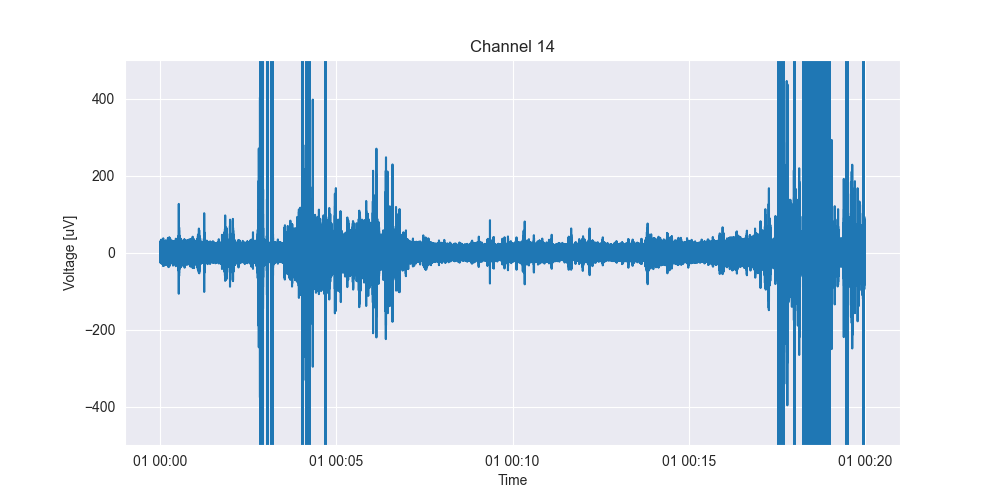

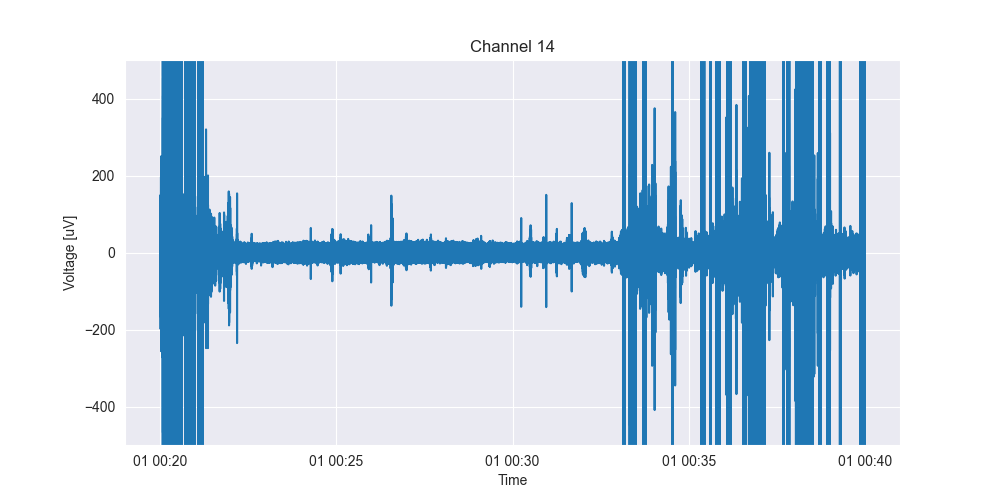

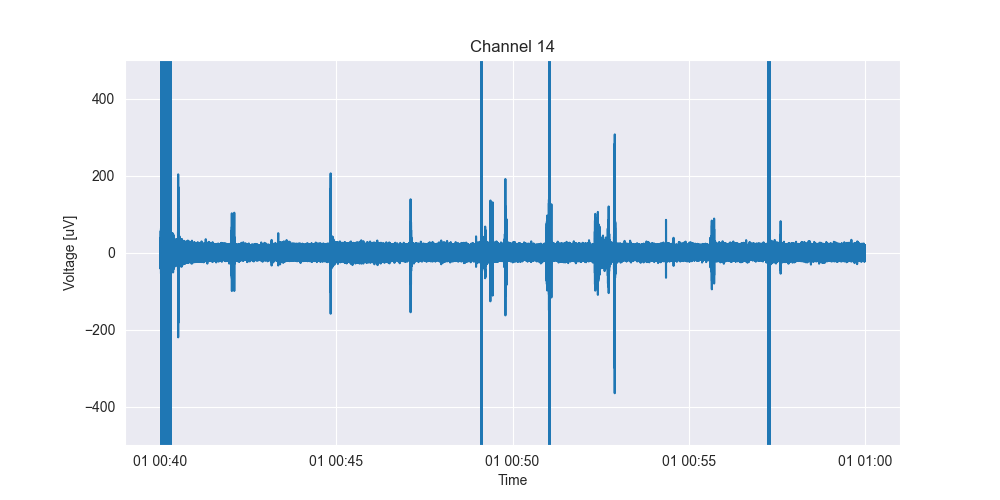

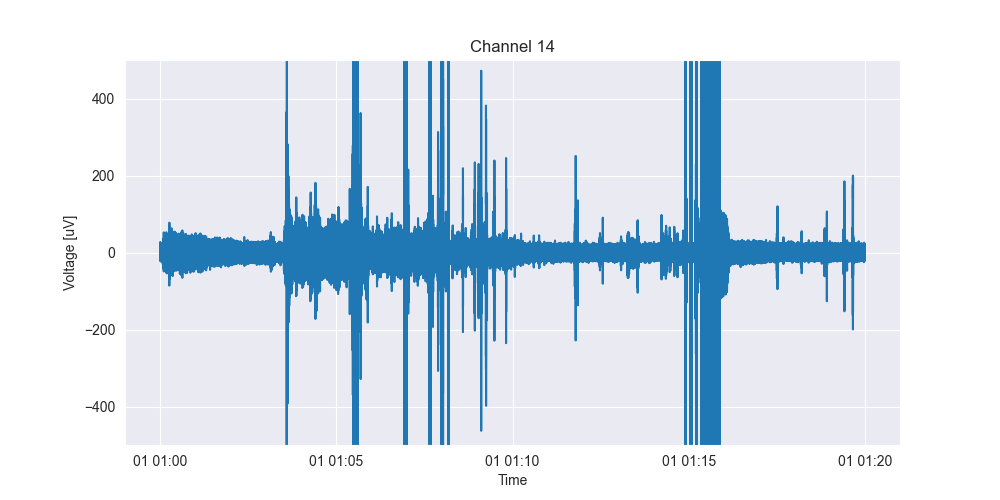

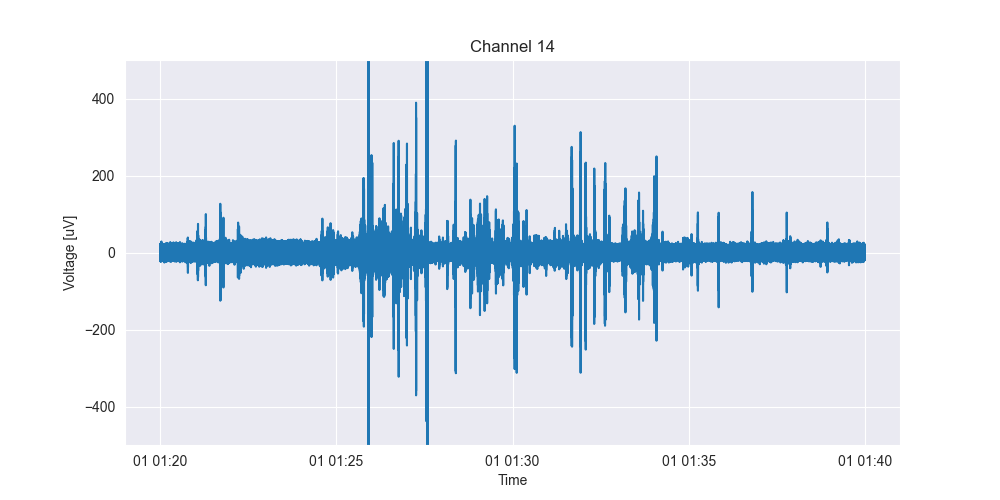

C:\Users\airbl\AppData\Local\Temp\ipykernel_26260\1539439351.py:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(10,5))


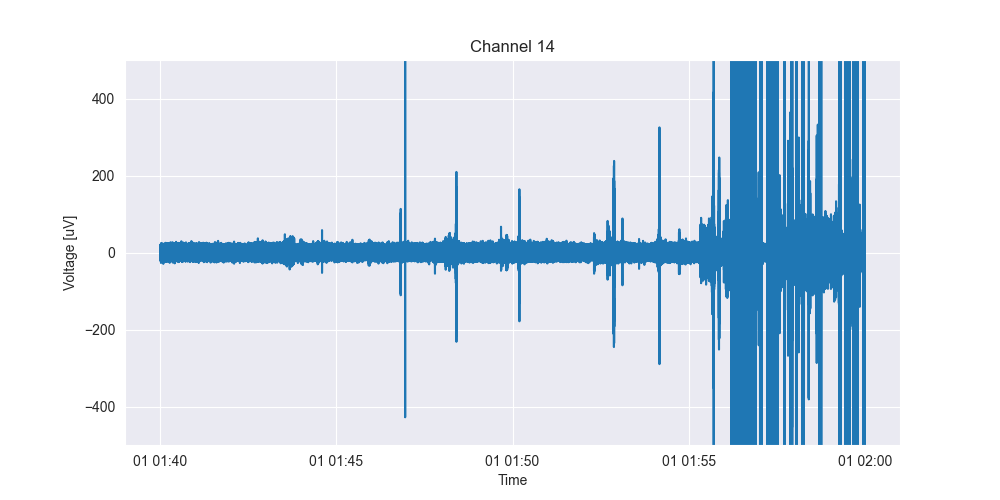

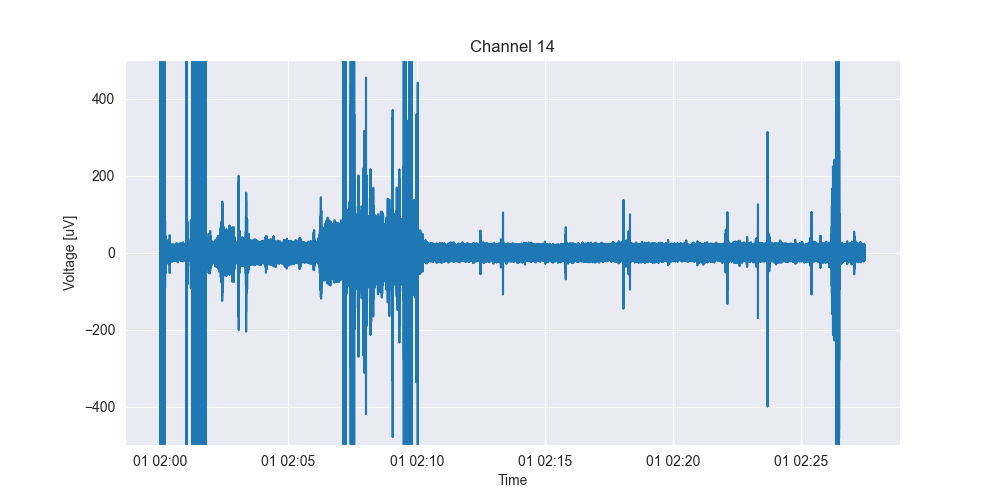

In [60]:
chunks = [
    [None, "02000"],
    ["02000", "04000"],
    ["04000", "06000"],
    ["06000", "08000"],
    ["08000", "10000"],
    ["10000", "12000"],
    ["12000", None]
]

for start, end in chunks:
    plot_single_channel(start_time=start, end_time=end, ylim=(-500, 500))

In [28]:
import time
import keyboard
import threading

def display_time(start_t, stop_event):
    while not stop_event.is_set():
        elapsed_time = time.time() - start_t
        print(f"\rCurrent Time: {elapsed_time:.2f} seconds", end="")
        time.sleep(0.01)  # Update every hundredth of a second

In [39]:
MA_times = []

In [34]:

def start_timer():
    start_time = time.time()
    stop_event = threading.Event()
    thread = threading.Thread(target=display_time, args=(start_time, stop_event))

    print("Timer started. Press the space bar to mark a timestamp. Press 'q' to quit.")
    thread.start()

    while True:
        try:
            if keyboard.is_pressed('space'):  # Press space bar to add a timestamp
                current_time = time.time() - start_time
                timestamp_in_10000ths = int(current_time * 10000)  # Convert to 10000ths of a second
                MA_times.append(timestamp_in_10000ths)
                print(f"\nTimestamp added: {timestamp_in_10000ths} (x10000 sec)")
                time.sleep(0.2)  # Adding a delay to avoid multiple detections

            if keyboard.is_pressed('q'):  # Press 'q' to quit
                stop_event.set()
                thread.join()
                print("\nExiting and printing all timestamps...")
                print(MA_times)
                break

        except:
            stop_event.set()
            thread.join()
            break

In [41]:
start_timer()

Timer started. Press the space bar to mark a timestamp. Press 'q' to quit.
Current Time: 7.96 seconds
Timestamp added: 79940364 (x10000 sec)
Current Time: 14.34 seconds
Timestamp added: 143678586 (x10000 sec)
Current Time: 15.72 seconds
Current Time: 15.75 seconds(x10000 sec)
Current Time: 17.20 seconds
Timestamp added: 171977822 (x10000 sec)
Current Time: 18.68 seconds
Timestamp added: 186783647 (x10000 sec)
Current Time: 21.25 seconds
Timestamp added: 212478406 (x10000 sec)
Current Time: 24.96 seconds
Timestamp added: 249638514 (x10000 sec)
Current Time: 26.45 seconds
Timestamp added: 264462959 (x10000 sec)
Current Time: 28.12 seconds
Timestamp added: 281229484 (x10000 sec)
Current Time: 33.11 seconds
Timestamp added: 331097359 (x10000 sec)
Current Time: 39.37 seconds
Timestamp added: 393835499 (x10000 sec)
Current Time: 44.41 seconds
Timestamp added: 444216611 (x10000 sec)
Current Time: 45.97 seconds
Timestamp added: 459868276 (x10000 sec)
Current Time: 48.71 seconds
Timestamp added

In [54]:
MA_times_0_10

[79940364,
 143678586,
 157513713,
 171977822,
 186783647,
 212478406,
 249638514,
 264462959,
 281229484,
 331097359,
 393835499,
 444216611,
 459868276,
 487454767,
 496354169,
 509867811,
 515306661,
 535448682,
 548830201,
 570893661,
 590612916,
 599096150,
 624271016,
 642913339,
 687797560,
 789374699,
 837689781,
 850243039,
 938266885,
 955718584,
 974193341,
 989627075,
 1034038436,
 1168993194,
 1185884628,
 1203181276,
 1270205926,
 1281312475,
 1300522296,
 1351922144,
 1382203435,
 1416431818,
 1474225361,
 1492061674,
 1523516535,
 1564696009,
 1589581248,
 1621575891,
 1651611945,
 1666038670,
 1675989706,
 1758298618,
 1764820141,
 1781351621,
 1791180346,
 1821479842,
 1832771582,
 1839920923,
 1850690081,
 1860597281,
 1870573356,
 1882921772,
 1908470957,
 2014878964,
 2026903131,
 2045671763,
 2062411882,
 2072756977,
 2078662650,
 2091012797,
 2101813023,
 2114006781,
 2134014005,
 2142376613,
 2161090373,
 2193706932,
 2211066946,
 2226598501,
 2245595407,
 22533

In [55]:
# Add 7 second offset to timestamps
MA_times_0_10 = [i//1000 + 70000 for i in MA_times_0_10]

## Code for saving timestamps to CSV files

In [45]:
import csv

In [56]:
filename = "Timestamps/Timestamps in 0-10 minutes Attempt 1.csv"

with open(filename, 'w', newline='') as file:
    writer = csv.writer(file)
    for time_index in MA_times_0_10:
        writer.writerow([time_index])

print(f"Data saved to {filename}")

Data saved to Timestamps/Timestamps in 0-10 minutes Attempt 1.csv


# Marking timestamps onto plot

In [57]:
MA_times_0_10

[149940,
 213678,
 227513,
 241977,
 256783,
 282478,
 319638,
 334462,
 351229,
 401097,
 463835,
 514216,
 529868,
 557454,
 566354,
 579867,
 585306,
 605448,
 618830,
 640893,
 660612,
 669096,
 694271,
 712913,
 757797,
 859374,
 907689,
 920243,
 1008266,
 1025718,
 1044193,
 1059627,
 1104038,
 1238993,
 1255884,
 1273181,
 1340205,
 1351312,
 1370522,
 1421922,
 1452203,
 1486431,
 1544225,
 1562061,
 1593516,
 1634696,
 1659581,
 1691575,
 1721611,
 1736038,
 1745989,
 1828298,
 1834820,
 1851351,
 1861180,
 1891479,
 1902771,
 1909920,
 1920690,
 1930597,
 1940573,
 1952921,
 1978470,
 2084878,
 2096903,
 2115671,
 2132411,
 2142756,
 2148662,
 2161012,
 2171813,
 2184006,
 2204014,
 2212376,
 2231090,
 2263706,
 2281066,
 2296598,
 2315595,
 2323380,
 2335411,
 2345085,
 2356449,
 2365478,
 2375203,
 2384087,
 2394512,
 2403744,
 2414091,
 2424489,
 2435561,
 2444500,
 2454870,
 2467044,
 2477025,
 2490151,
 2506183,
 2515392,
 2521783,
 2531714,
 2542169,
 2552985,
 2562928

In [63]:
# Do first 10 minutes

def plot_timestamps(channel=record.channels[0], start_time=None, end_time=None, ylim=None, timestamps=None):
    """
    Plots one individual channel really wide, with scroller.
    
    start_time, end_time : [string] in mmmss format e.g. 2 hr 10 min 30 sec -> 13030(xxxx)
                               ....(xxxx) optional - numbers behind the decimal point to specify fractions of a second
    """
    if start_time is None:
        start_index = 0
    else:
        start_index = 0
        start_index += int(start_time[:3]) * 60 * Recording.window_length
        start_index += int(start_time[3:5]) * Recording.window_length
        if len(start_time) == 9:
            start_index += int(start_time[5:])

    if end_time is None:
        end_index = len(record.recording.index)
    else:
        end_index = 0
        end_index += int(end_time[:3]) * 60 * Recording.window_length
        end_index += int(end_time[3:5]) * Recording.window_length
        if len(end_time) == 9:
            end_index += int(end_time[5:])
    
    fig, ax = plt.subplots(figsize=(20,10))
    x_range = [i for i in range(start_index, end_index)]
    signal = record.filtered['ch_%s' % channel][x_range]
    ax.plot(record.recording.index[x_range], signal)
    ax.set_title("Channel %s" % channel)
    ax.set_xlabel('Time')
    ax.set_ylabel('Voltage [uV]')
    if timestamps is not None:
        for t in timestamps:
            ax.axvline(x=record.recording.index[t], color="purple", linewidth=0.5, alpha=1.0)

    if ylim is not None:
        ax.set_ylim(ylim[0], ylim[1])
    plt.show()

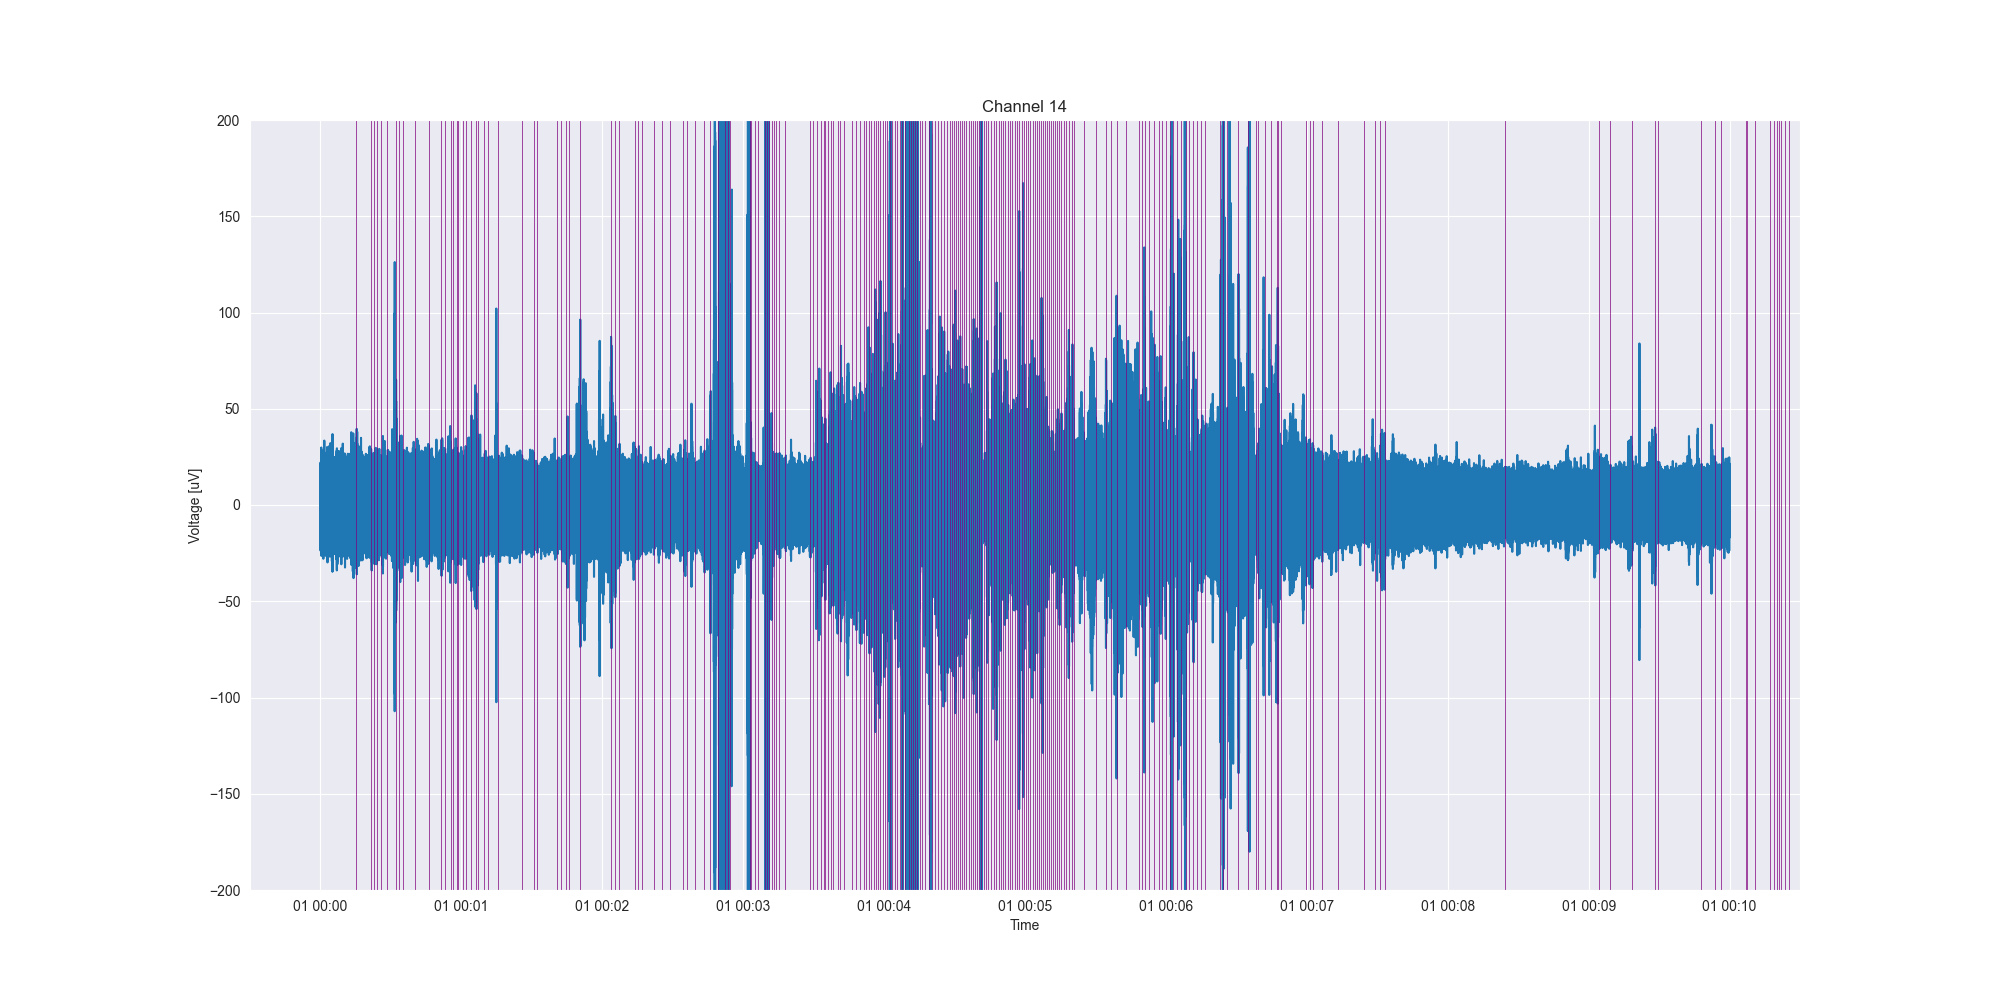

In [64]:
plot_timestamps(start_time=None, end_time="01000", timestamps=MA_times_0_10, ylim=(-200, 200))